# Lab 8 - Transfer Learning

- Diego Linares - 22156
- Christian Echeverría - 221441

### Imports y creacion del ambiente

In [16]:
import os, math, time, copy, random
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [17]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # reduce fragmentación
torch.backends.cudnn.benchmark = True  # kernels más estables/rápidos

### Configuración rapida

In [18]:
DATASET = 'CIFAR10'   # 'CIFAR10' o 'CIFAR100'
DATA_DIR = './data'   # ruta de descarga/lectura
IMG_SIZE = 160        # VGG16 espera 224x224

BATCH_SIZE = 32
NUM_WORKERS = 2

EPOCHS_FE = 5         # feature extraction
EPOCHS_FT = 8         # fine-tuning

LR_FE = 1e-3
LR_FT = 1e-4          # más pequeño para fine-tuning
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9
PATIENCE = 3          # early stopping

EPOCHS_FE = max(3, EPOCHS_FE)   # por seguridad, bajamos un poco
EPOCHS_FT = max(5, EPOCHS_FT)

ACCUM_STEPS = 2         # acumulación de gradientes: simula batch 32*2 = 64 efectivo
USE_AMP = True          # mixed precision


### Transforms + Datasets + Dataloaders

In [19]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

if DATASET.upper() == 'CIFAR10':
    train_set = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tfms)
    test_set  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tfms)
elif DATASET.upper() == 'CIFAR100':
    train_set = datasets.CIFAR100(root=DATA_DIR, train=True, download=True, transform=train_tfms)
    test_set  = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=test_tfms)
else:
    raise ValueError('DATASET debe ser CIFAR10 o CIFAR100')

NUM_CLASSES = len(train_set.classes)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

NUM_CLASSES

10

### Utilidades: accuracy, evaluar, entrenar, plot

In [20]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            acc = accuracy_from_logits(logits, y)
            bs = y.size(0)
            total_loss += loss.item() * bs
            total_acc  += acc * bs
            total_n    += bs
            all_preds.append(logits.argmax(1).cpu())
            all_targets.append(y.cpu())
    avg_loss = total_loss / total_n
    avg_acc  = total_acc / total_n
    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    return avg_loss, avg_acc, preds.numpy(), targets.numpy()

def train_model_amp(model, train_loader, val_loader, optimizer, criterion,
                    epochs=10, scheduler=None, patience=3, tag='run',
                    use_amp=True, accum_steps=1, device=DEVICE):
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=use_amp)

    best_w = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    wait = 0

    for ep in range(1, epochs+1):
        model.train()
        running_loss, running_acc, running_n = 0.0, 0.0, 0
        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc=f'Epoch {ep}/{epochs} [{tag}]', leave=False)
        for step, (x, y) in enumerate(pbar, 1):
            x, y = x.to(device), y.to(device)
            with autocast(enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y) / accum_steps

            scaler.scale(loss).backward()

            if step % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * y.size(0) * accum_steps
            running_acc  += (logits.argmax(1) == y).float().sum().item()
            running_n    += y.size(0)

        if scheduler is not None:
            scheduler.step()

        train_loss = running_loss / running_n
        train_acc  = running_acc  / running_n
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_w = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(best_w)
    return model, history, best_acc

def plot_history(history, title='training'):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss — {title}'); plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy — {title}'); plt.legend(); plt.show()

### Construcción de VGG16 y helpers

In [21]:
def build_vgg16(num_classes, pretrained=True):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

def freeze_features(model):
    for p in model.features.parameters():
        p.requires_grad = False
    return model

def params_trainable(model):
    return [p for p in model.parameters() if p.requires_grad]

NUM_CLASSES


10

### (a) Baseline: sin entrenamiento adicional

In [22]:
criterion = nn.CrossEntropyLoss()

model_a = build_vgg16(NUM_CLASSES, pretrained=True).to(DEVICE)
test_loss_a, test_acc_a, preds_a, targets_a = evaluate(model_a, test_loader, criterion)
print({'test_loss': round(test_loss_a, 4), 'test_acc': round(test_acc_a, 4)})

{'test_loss': 2.3488, 'test_acc': 0.0929}


### (b) Feature Extraction (congelar features)

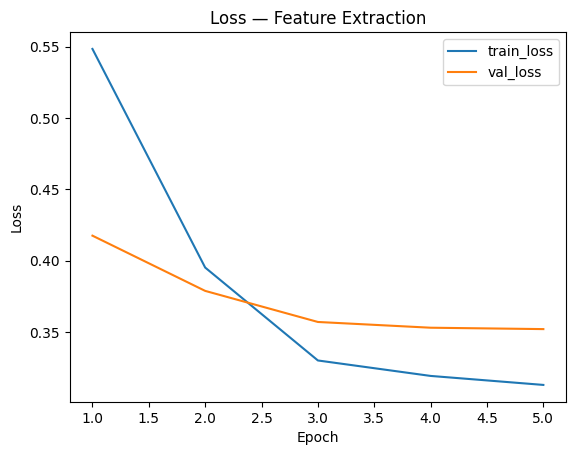

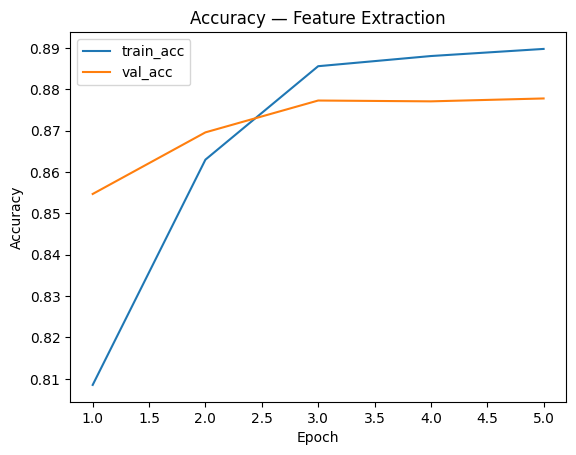

{'best_val_acc': 0.8778, 'test_loss': 0.352, 'test_acc': 0.8778}


In [23]:
model_b = build_vgg16(NUM_CLASSES, pretrained=True)
model_b = freeze_features(model_b).to(DEVICE)

optimizer_b = optim.SGD(params_trainable(model_b), lr=LR_FE,
                        momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler_b = optim.lr_scheduler.StepLR(optimizer_b, step_size=max(EPOCHS_FE//2,1), gamma=0.1)

model_b, hist_b, best_b = train_model(model_b, train_loader, test_loader, optimizer_b, criterion,
                                      epochs=EPOCHS_FE, scheduler=scheduler_b,
                                      patience=PATIENCE, tag='feature-extract')

test_loss_b, test_acc_b, preds_b, targets_b = evaluate(model_b, test_loader, criterion)
plot_history(hist_b, title='Feature Extraction')
print({'best_val_acc': round(best_b, 4), 'test_loss': round(test_loss_b, 4), 'test_acc': round(test_acc_b, 4)})


### (c) Fine-Tuning (descongelar todo con LR pequeño)

In [24]:
try:
    del model_a, preds_a, targets_a
except:
    pass
try:
    del model_b, preds_b, targets_b, hist_b
except:
    pass

import gc, torch
gc.collect()
torch.cuda.empty_cache()

print("Memoria liberada. Listo para FT.")

Memoria liberada. Listo para FT.


/tmp/ipython-input-782481751.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
Epoch 1/8 [fine-tune]:   0%|          | 0/1563 [00:00<?, ?it/s]/tmp/ipython-input-782481751.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


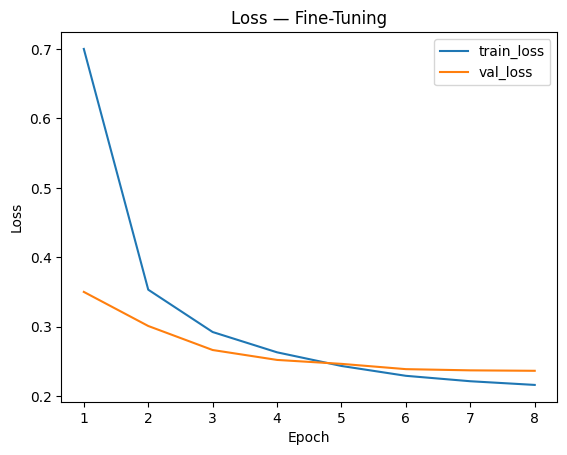

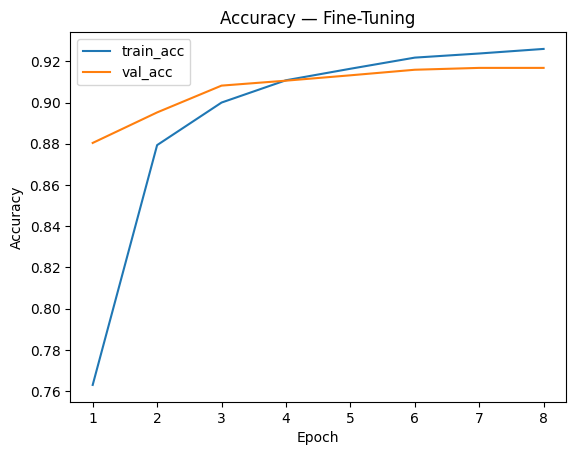

{'best_val_acc': 0.9168, 'test_loss': 0.2371, 'test_acc': 0.9168}


In [25]:
criterion = nn.CrossEntropyLoss()

model_c = build_vgg16(NUM_CLASSES, pretrained=True).to(DEVICE)
for p in model_c.parameters():
    p.requires_grad = True

optimizer_c = optim.SGD(model_c.parameters(), lr=LR_FT,
                        momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler_c = optim.lr_scheduler.CosineAnnealingLR(optimizer_c, T_max=EPOCHS_FT)

model_c, hist_c, best_c = train_model_amp(
    model_c, train_loader, test_loader, optimizer_c, criterion,
    epochs=EPOCHS_FT, scheduler=scheduler_c, patience=PATIENCE, tag='fine-tune',
    use_amp=USE_AMP, accum_steps=ACCUM_STEPS, device=DEVICE
)

test_loss_c, test_acc_c, preds_c, targets_c = evaluate(model_c, test_loader, criterion)
plot_history(hist_c, title='Fine-Tuning')
print({'best_val_acc': round(best_c, 4), 'test_loss': round(test_loss_c, 4), 'test_acc': round(test_acc_c, 4)})


### Resumen y CSV

In [28]:
import pandas as pd
import numpy as np

def _has(*names):
    g = globals()
    return all((n in g) and (g[n] is not None) for n in names)

rows = []

# (a) no-train
if _has('test_loss_a', 'test_acc_a'):
    rows.append({
        'scenario': 'a_no_train',
        'train_loss': np.nan, 'train_acc': np.nan, 'val_best_acc': np.nan,
        'test_loss': float(test_loss_a), 'test_acc': float(test_acc_a),
    })

# (b) feature extraction
if _has('hist_b', 'test_loss_b', 'test_acc_b'):
    rows.append({
        'scenario': 'b_feature_extraction',
        'train_loss': float(hist_b['train_loss'][-1]) if len(hist_b['train_loss']) else np.nan,
        'train_acc': float(hist_b['train_acc'][-1]) if len(hist_b['train_acc']) else np.nan,
        'val_best_acc': float(max(hist_b['val_acc'])) if len(hist_b['val_acc']) else np.nan,
        'test_loss': float(test_loss_b), 'test_acc': float(test_acc_b),
    })

# (c) fine-tuning
if _has('hist_c', 'test_loss_c', 'test_acc_c'):
    rows.append({
        'scenario': 'c_fine_tuning',
        'train_loss': float(hist_c['train_loss'][-1]) if len(hist_c['train_loss']) else np.nan,
        'train_acc': float(hist_c['train_acc'][-1]) if len(hist_c['train_acc']) else np.nan,
        'val_best_acc': float(max(hist_c['val_acc'])) if len(hist_c['val_acc']) else np.nan,
        'test_loss': float(test_loss_c), 'test_acc': float(test_acc_c),
    })

if not rows:
    raise RuntimeError(
        "No hay resultados disponibles para resumir. "
        "Corre al menos uno de los escenarios (a/b/c) antes de esta celda."
    )

summary = pd.DataFrame(rows)
display(summary)

import os
os.makedirs('artefactos', exist_ok=True)
csv_path = 'artefactos/resultados_resumen.csv'
summary.to_csv(csv_path, index=False)

print(f"✅ Resumen guardado en: {csv_path}")
summary

,scenario,train_loss,train_acc,val_best_acc,test_loss,test_acc
0,a_no_train,NaN,NaN,NaN,2.348796,0.0929
1,c_fine_tuning,0.21614,0.926,0.9168,0.237131,0.9168


✅ Resumen guardado en: artefactos/resultados_resumen.csv


,scenario,train_loss,train_acc,val_best_acc,test_loss,test_acc
0,a_no_train,NaN,NaN,NaN,2.348796,0.0929
1,c_fine_tuning,0.21614,0.926,0.9168,0.237131,0.9168


### Matriz de confusión + reporte de clasificación (FT)

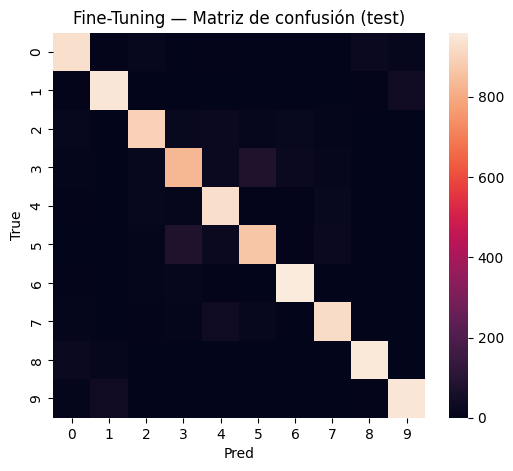

              precision    recall  f1-score   support

    airplane       0.92      0.93      0.92      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.92      0.89      0.91      1000
         cat       0.86      0.83      0.84      1000
        deer       0.89      0.93      0.91      1000
         dog       0.88      0.86      0.87      1000
        frog       0.94      0.96      0.95      1000
       horse       0.93      0.92      0.92      1000
        ship       0.96      0.95      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [29]:
import seaborn as sns

plt.figure(figsize=(6,5))
cm = confusion_matrix(targets_c, preds_c)
sns.heatmap(cm, annot=False, fmt='d')
plt.title('Fine-Tuning — Matriz de confusión (test)')
plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

print(classification_report(targets_c, preds_c, target_names=train_set.classes))


### Guardar pesos de los modelos

In [32]:
import os, torch
os.makedirs('artefactos', exist_ok=True)

def save_if_exists(var_name: str, filepath: str):
    m = globals().get(var_name, None)
    if m is None:
        print(f"ℹ️ {var_name} no existe en memoria (probablemente se liberó). No se guarda {filepath}.")
        return
    try:
        torch.save(m.state_dict(), filepath)
        print(f"✅ Guardado: {filepath}")
    except Exception as e:
        print(f"⚠️ Error al guardar {var_name} en {filepath}: {e}")

save_if_exists('model_a', 'artefactos/vgg16_a_no_train.pt')
save_if_exists('model_b', 'artefactos/vgg16_b_feature_extraction.pt')
save_if_exists('model_c', 'artefactos/vgg16_c_fine_tuning.pt')

sorted(os.listdir('artefactos'))

ℹ️ model_a no existe en memoria (probablemente se liberó). No se guarda artefactos/vgg16_a_no_train.pt.
ℹ️ model_b no existe en memoria (probablemente se liberó). No se guarda artefactos/vgg16_b_feature_extraction.pt.
✅ Guardado: artefactos/vgg16_c_fine_tuning.pt


['resultados_resumen.csv', 'vgg16_c_fine_tuning.pt']

## Discusión

In [31]:
from IPython.display import Markdown, display

def reporte_markdown(summary_df):
    best = summary_df.iloc[summary_df['test_acc'].idxmax()]
    texto = f"""
### Discusión breve
- **Mejor rendimiento**: `{best['scenario']}` con *test_acc* = {best['test_acc']:.4f}.
- **Feature extraction vs fine-tuning**: típicamente FT supera FE porque ajusta todas las capas al *domain shift* de CIFAR,
  pero tarda más y puede sobreajustar si el LR no es pequeño.
- **Eficiencia**: FE es más eficiente (menos parámetros entrenables). No-train sirve como *baseline* rápida.
"""
    display(Markdown(texto))

reporte_markdown(summary)


### Discusión breve
- **Mejor rendimiento**: `c_fine_tuning` con *test_acc* = 0.9168.
- **Feature extraction vs fine-tuning**: típicamente FT supera FE porque ajusta todas las capas al *domain shift* de CIFAR,
  pero tarda más y puede sobreajustar si el LR no es pequeño.
- **Eficiencia**: FE es más eficiente (menos parámetros entrenables). No-train sirve como *baseline* rápida.
